In this notebook, a scope for the amide datasets is generated using the clustering approach introduced by Glorius and co-workers (ACS Cent. Sci. 2024, 10, 899-906). As the three datasets only differ in the yield data which is not considered in the selection process, the clustering will only be conducted once. Furthermore, as the clustering algorithm is not compatible with smiles of substrate combinations (here: acid + amine), the smiles of the reaction products (amides) are used as input for the algorithm.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from Code.predictor import ScopeBO
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import shutil
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from Code.benchmark import Benchmark
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys

# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14, # Legend titles
    "font.family": "Helvetica"   # Font
    })

In [2]:
# define a couple things
objectives = ["yield"]
directory = "."
wdir = Path(directory)
datasets = ["high","medium","low"]

In [3]:
def generate_representation(smiles_list,common_core="c1ccccc1I"):
    """Generate a representation to visualize the scope substrates."""
    # Convert to molecules
    mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

    # Generate 2D coordinates for all mols
    for mol in mol_list:
        AllChem.Compute2DCoords(mol)

    # Define iodobenzene substructure for alignment
    core = Chem.MolFromSmarts(common_core)
    AllChem.Compute2DCoords(core)

    # Align each molecule to the substructure if it matches
    for mol in mol_list:
        if mol.HasSubstructMatch(core):
            AllChem.GenerateDepictionMatching2DStructure(mol, core)

    return mol_list

In [4]:
def assign_clusterpoints(df_clusterpoints,df_dataset):
    """Assigns the selected cluster points to the dataset by comparison of canonical smiles. Also assigns the yield labels to the cluster points dataframe."""
    # generate a new column with canonical smiles in both dataframes
    df_data = df_dataset.copy()
    for df in [df_clusterpoints,df_data]:
        smiles_labelled = list(df.index)
        mol_labelled = [Chem.MolFromSmiles(smiles) for smiles in smiles_labelled]
        can_labelled = [Chem.MolToSmiles(mol,canonical=True, isomericSmiles=False) for mol in mol_labelled]  # canonical smiles
        df["can"] = can_labelled
    
    # only keep the yield labels for datapoints in the df_clusterpoints
    df_data.loc[~df_data["can"].isin(set(df_clusterpoints["can"])),"yield"] = 'PENDING'

    # assign the yield labels to df_clusterpoints
    for smiles in df_clusterpoints["can"]:
        df_clusterpoints.loc[df_clusterpoints["can"]==smiles,"yield"] = df_data.loc[df_data["can"]==smiles,"yield"].values[0]

    df_data.drop(axis=1,labels="can",inplace=True)
    df_clusterpoints.drop(axis=1,labels="can",inplace=True)

    return df_clusterpoints, df_data


In [5]:
# load the normalization bounds
df_bounds = pd.read_csv(f"./../Amide_data/Datasets/bounds_subs.csv", index_col=0)
df_bounds.iloc[:2] = df_bounds.iloc[:2].apply(lambda x: x*100)

# define a function to extract the relevant bounds in a format suitable for the Benchmark class
def get_bounds(dset,scale_back=False):
    bounds_df = df_bounds.copy()
    if scale_back:
        bounds_df.iloc[:2] = bounds_df.iloc[:2].apply(lambda x: x/100)

    bounds = {}
    # get the metrics for the yield objective
    bounds["yield"] = (bounds_df.loc["obj_max",dset],bounds_df.loc["obj_min",dset])
    # get the metrics for the vendi score
    bounds["vendi"] = (bounds_df.loc["vendi_max",dset],bounds_df.loc["vendi_min",dset])

    return bounds

# function to calculate the scope score
def calculate_scope_score(av_yield,Vendi_score,bounds):
    scaled_yield = (av_yield - bounds["yield"][1])/(bounds["yield"][0] - bounds["yield"][1])
    scaled_Vendi = (Vendi_score - bounds["vendi"][1])/(bounds["vendi"][0] - bounds["vendi"][1])

    return scaled_yield * scaled_Vendi

In [6]:
def umap_representation(data_clust,dset,ax,dict_class = None):
    """Creates a plt axes object with the selected samples visualized on a UMAP."""
    
    df_umap = pd.read_csv(f"./../Amide_data/Datasets/umap_subs_{dset}.csv",index_col=0,header=0)

    # replace the substrate smiles with the product ones
    prod_index = [conv.loc[conv["Combinations"] == smiles, "Products"].values[0] for smiles in df_umap.index]
    df_umap.index = prod_index
    df_umap["yield"] = df_umap["yield"]*100

    # Define colormap and normalization
    vmin = df_umap['yield'].min()
    vmax = df_umap['yield'].max()
    norm = plt.Normalize(vmin, vmax)
    cmap = sns.color_palette("Doyle_cont", as_cmap=True)

    full_scope = data_clust.index.to_list()
    if dict_class is not None:
        full_scope += list(dict_class.keys())

    # assign scope samples
    df_umap["status"] = "none"
    if dict_class is not None:
        df_umap.loc[df_umap.index.isin(set(dict_class.keys())), "status"] = "classical"
    df_umap.loc[df_umap.index.isin(data_clust[data_clust["yield"] != "PENDING"].index), "status"] = "clustering"

    # remove yields for non-selected compounds
    df_umap.loc[df_umap["status"] == "none", "yield"] = "PENDING"

    # Plot the non-selected samples
    df_map_pending = df_umap.loc[df_umap["status"] == "none"].copy()
    ax.scatter(df_map_pending["UMAP1"], df_map_pending["UMAP2"], color=all_colors[6], s=20, alpha=0.4, label="not selected")

    # Plot entries of the clustering scope
    df_map_clust = df_umap.loc[df_umap["status"] == "clustering"].copy()

    scatter_cluster = ax.scatter(df_map_clust["UMAP1"],df_map_clust["UMAP2"], label="clustering",
                                 c=df_map_clust["yield"],cmap=cmap,norm=norm, marker="o",
                                 s=100,alpha=1,edgecolor='k',linewidth=1)
    
    # Plot entries of the classical scope (if is exists)
    if dict_class is not None:
        df_map_class = df_umap.loc[df_umap["status"] == "classical"].copy()
        ax.scatter(df_map_class["UMAP1"],df_map_class["UMAP2"], label = "classical",
                                    c=df_map_class["yield"],cmap=cmap,norm=norm,marker="s",
                                    s=100,alpha=1,edgecolor='k',linewidth=1)

    # Add colorbar
    cbar = fig.colorbar(scatter_cluster,ax=ax)
    cbar.set_label("Yield (%)")

    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")

The scope was created using the webapp https://pharmascope.uni-muenster.de/ using the recommended settings (15 clusters to generate 15 compounds and using the provided standard UMAP 0_ECFP_2_512_UMAP_2dim_30nb_0.1mindist_jaccard.model).

In [7]:
# the clustering algorithm by Glorius and co-workers takes SMILES strings as the input.
# As the algorithm is not compatible with SMILES of substrate combinations, we used the product SMILES (amides) instead

# Load the smiles list
conv = pd.read_csv(f"./../Amide_data/Datasets/0_Descriptor_Generation/amide_smiles_products_filtered.csv",
                        names=["Products","Combinations"])
smiles_list = conv["Products"].to_list()
pd.DataFrame(smiles_list,index=None,columns=None).to_csv(f"./Results_Data/Cluster_Scopes/Glorius_Smiles_Lists"\
                                                         "/amide_smiles_list.txt",index=False,header=False)

# also read in the dfs with the result data
dfs_labelled = {}
for dset in datasets:
    dfs_labelled[dset] = pd.read_csv(f"./../Amide_data/Datasets/amide_dset_dft_prod_{dset}-yielding.csv",index_col=0)


A list of the product SMILES strings of all amides dataset was provided as the input and the top-1 substrate per cluster was requested.

After using the webapp, the results can be read in.

Products selected by the clustering algorithm for the high dataset:


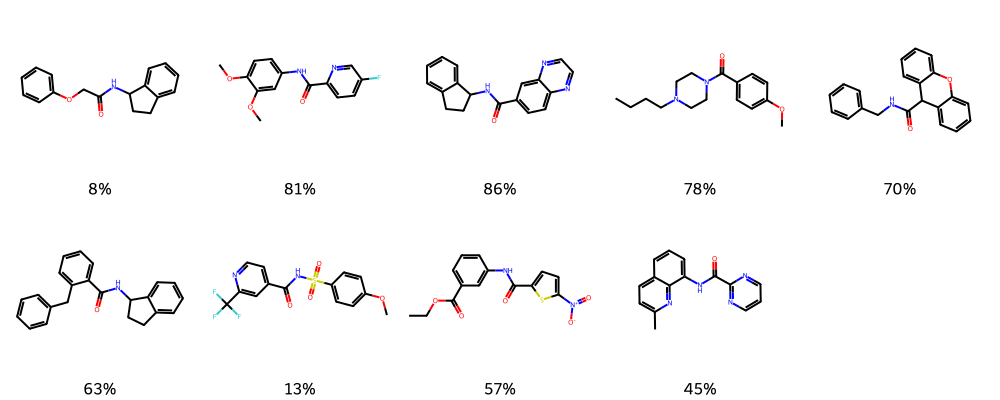

Number of selected compounds: 9



Products selected by the clustering algorithm for the medium dataset:


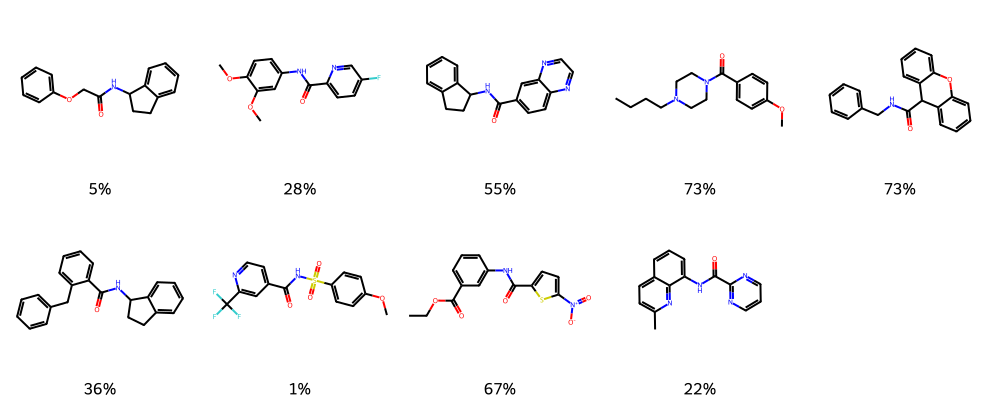

Number of selected compounds: 9



Products selected by the clustering algorithm for the low dataset:


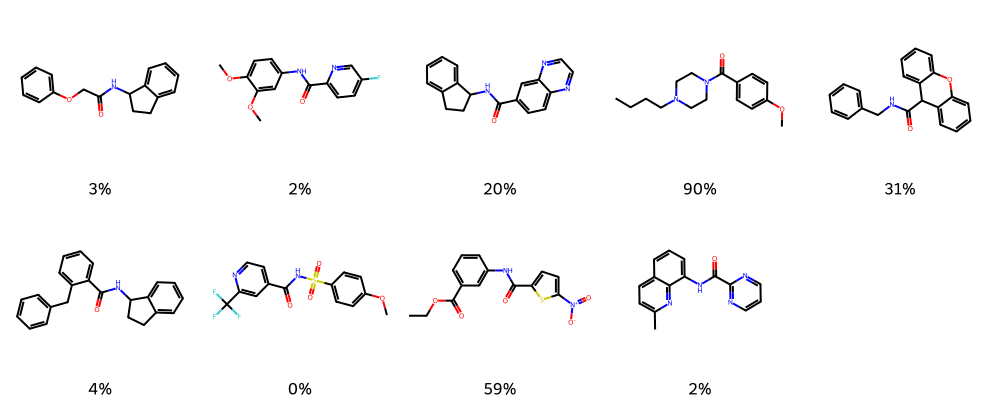

Number of selected compounds: 9


In [8]:
scope_results_15clu = pd.DataFrame(np.nan,index=datasets,columns=["Scope size","Average yield (%)","Vendi score","Scope score"])
dfs_clustering = {}
dfs_data = {}
for dset in datasets:
    dfs_clustering[dset] = pd.read_csv(f"./Results_Data/Cluster_Scopes/scope_glorius_smiles_15clusters.csv",
                                       index_col=0,header=0)
    dfs_clustering[dset].set_index("smiles",inplace=True)

    dfs_clustering[dset], dfs_data[dset] = assign_clusterpoints(df_clusterpoints=dfs_clustering[dset],
                                                                df_dataset=dfs_labelled[dset])

    mol_list = generate_representation(list(dfs_clustering[dset].index))
    depiction = Draw.MolsToGridImage(
        mol_list,
        molsPerRow=5,
        subImgSize=(200, 200),
        legends=[f"{round(dfs_clustering[dset].loc[smiles,'yield']*100)}%" for smiles in dfs_clustering[dset].index]
        )
    print(f"Products selected by the clustering algorithm for the {dset} dataset:")
    display(depiction)

    print(f'Number of selected compounds: {len(dfs_clustering[dset])}')
    scope_results_15clu.loc[dset,"Scope size"] = len(dfs_clustering[dset])
    if dset != "low":
        print("\n\n")

Notably, in each dataset, no compounds were selected for some clusters, presumably because the amides in our dataset are too dissimilar from the drug substrates in these clusters that form the basis for the amide selection. Thus, only 9 samples were generated instead of the 15 samples that were recommended in the publication by Glorius and co-workers.

We can now look at the average yield data, vendi score, and scope score of this scope.

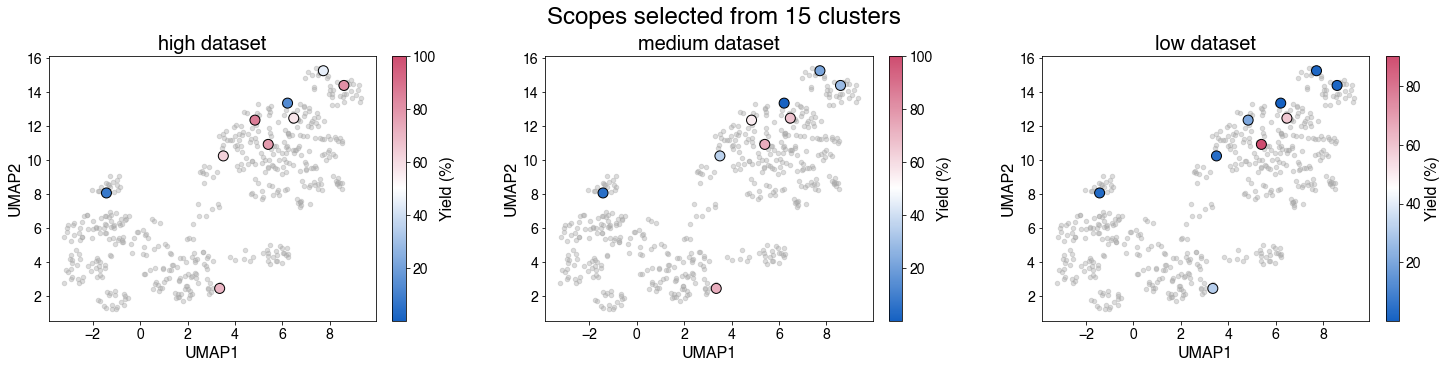

,Scope size,Average yield (%),Vendi score,Scope score
high,9.0,55.725122,3.128,0.006
medium,9.0,39.926646,3.128,0.019
low,9.0,23.415378,3.128,0.014


In [9]:
fig,axes = plt.subplots(1,3,figsize=(20,5),gridspec_kw={"wspace":0.1},constrained_layout=True)
fig.suptitle("Scopes selected from 15 clusters")
for i,dset in enumerate(datasets):
    ax = axes[i]
    av_yield = dfs_clustering[dset]["yield"].mean()*100
    scope_results_15clu.loc[dset,"Average yield (%)"] = av_yield
    dfs_data[dset].to_csv("df_vendi.csv",index=True,header=True)
    vendi_score = ScopeBO().get_vendi_score(objectives=["yield"],filename="df_vendi.csv")
    scope_results_15clu.loc[dset,"Vendi score"] = round(vendi_score,3)
    bounds = get_bounds(dset)
    scope_score = calculate_scope_score(av_yield,vendi_score,bounds)
    scope_results_15clu.loc[dset,"Scope score"] = round(scope_score,3)
    ax.set_title(f"{dset} dataset")
    umap_representation(dfs_data[dset],dset,ax)
plt.show()
scope_results_15clu

In [10]:
print("Normalization bounds for comparison:")
df_bounds.applymap(lambda x: round(x,3)).T

Normalization bounds for comparison:


,obj_min,obj_max,vendi_min,vendi_max
high,52.463,70.585,2.889,9.740
medium,34.432,44.152,2.904,9.732
low,15.296,34.736,2.895,9.771


The scope score is approximately 0 for these 9 samples as the Vendi score is quite low. Examination of the UMAPs shows that despite the low number of samples some of the samples are very close to each other on the UMAPs which could indicate high similarity. This might be caused in part by the use of fingerprint featurization in the Glorius' algorithm whereas the Vendi scores and UMAPs are calculated using DFT features. Still, the fact that not all clusters could be used to assign a sample (see above) hints at the algorithm not being fully compatible with this dataset.

As Glorius and co-workers recommended to generate 15 samples using their clustering approach, we increased the number of clusters until 15 samples were generated for each dataset which was the case by using 24 clusters.

Products selected by the clustering algorithm for the high dataset:


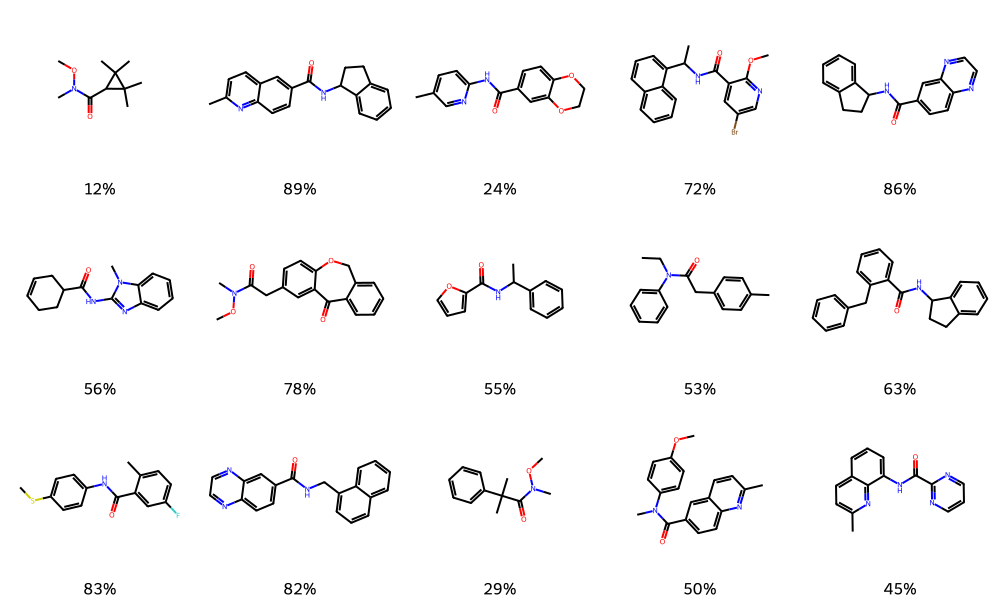

Number of selected compounds: 15



Products selected by the clustering algorithm for the medium dataset:


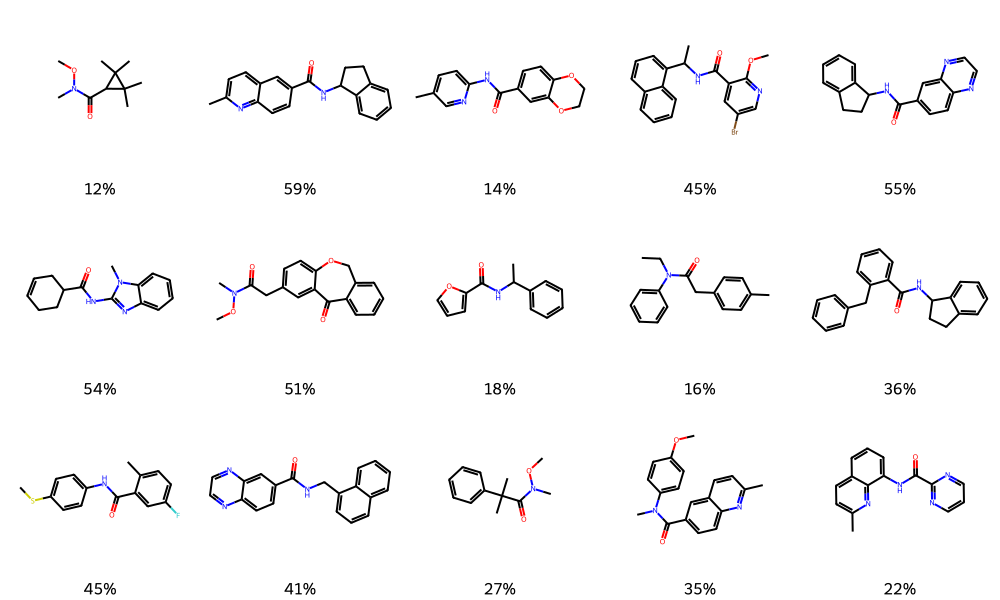

Number of selected compounds: 15



Products selected by the clustering algorithm for the low dataset:


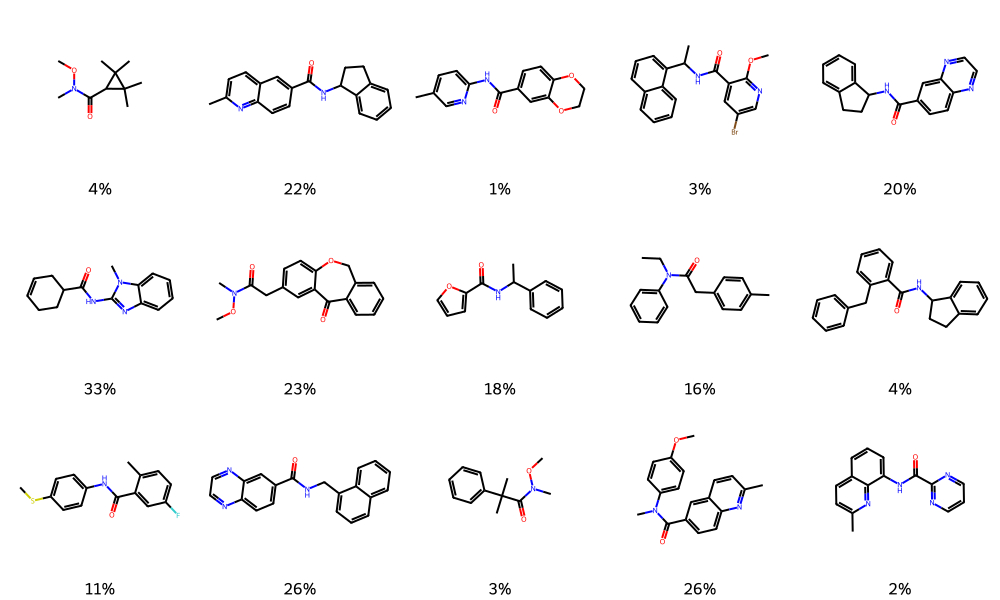

Number of selected compounds: 15


In [11]:
# Read in the selected substrates and visualize them
scope_results_15sam = pd.DataFrame(np.nan,index=datasets,columns=["Nr clusters","Scope size","Average yield (%)","Vendi score","Scope score"])
scope_results_15sam["Nr clusters"] = 24
dfs_clustering = {}
dfs_data = {}
for dset in datasets:
    dfs_clustering[dset] = pd.read_csv(f"./Results_Data/Cluster_Scopes/scope_glorius_smiles_15samples.csv",index_col=0,header=0)
    dfs_clustering[dset].set_index("smiles",inplace=True)

    dfs_clustering[dset], dfs_data[dset] = assign_clusterpoints(df_clusterpoints=dfs_clustering[dset],df_dataset=dfs_labelled[dset])

    mol_list = generate_representation(list(dfs_clustering[dset].index))
    depiction = Draw.MolsToGridImage(
        mol_list,
        molsPerRow=5,
        subImgSize=(200, 200),
        legends=[f"{round(dfs_clustering[dset].loc[smiles,'yield']*100)}%" for smiles in dfs_clustering[dset].index]
        )
    print(f"Products selected by the clustering algorithm for the {dset} dataset:")
    display(depiction)

    print(f'Number of selected compounds: {len(dfs_clustering[dset])}')
    scope_results_15sam.loc[dset,"Scope size"] = len(dfs_clustering[dset])
    if dset != "low":
        print("\n\n")

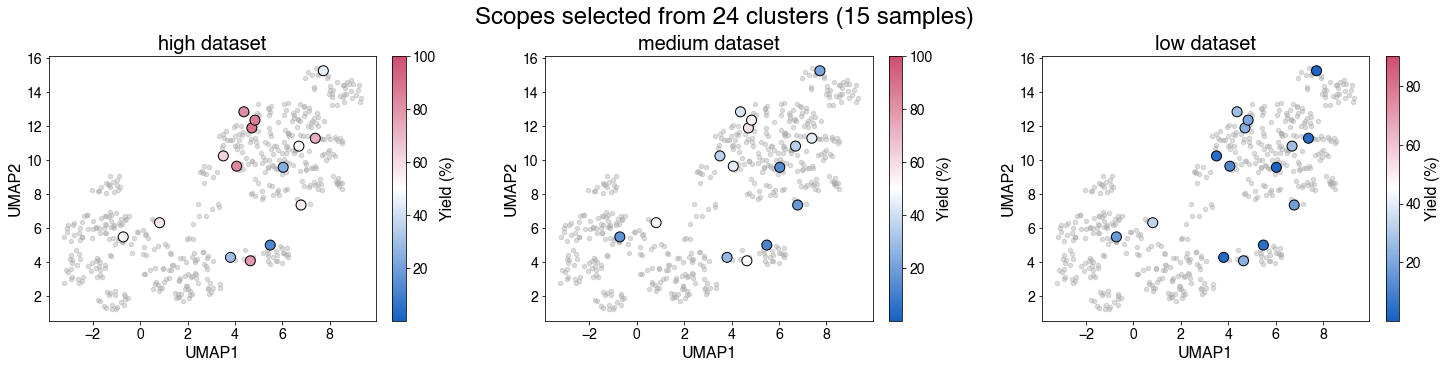

,Nr clusters,Scope size,Average yield (%),Vendi score,Scope score
high,24,15.0,58.566,3.912,0.050
medium,24,15.0,35.276,3.912,0.013
low,24,15.0,14.065,3.912,-0.009


In [12]:
fig,axes = plt.subplots(1,3,figsize=(20,5),gridspec_kw={"wspace":0.1},constrained_layout=True)
fig.suptitle("Scopes selected from 24 clusters (15 samples)")
for i,dset in enumerate(datasets):
    ax = axes[i]
    av_yield = dfs_clustering[dset]["yield"].mean()*100
    scope_results_15sam.loc[dset,"Average yield (%)"] = round(av_yield,3)
    dfs_data[dset].to_csv("df_vendi.csv",index=True,header=True)
    vendi_score = ScopeBO().get_vendi_score(objectives=["yield"],filename="df_vendi.csv")
    scope_results_15sam.loc[dset,"Vendi score"] = round(vendi_score,3)
    bounds = get_bounds(dset)
    scope_score = calculate_scope_score(av_yield,vendi_score,bounds)
    scope_results_15sam.loc[dset,"Scope score"] = round(scope_score,3)
    ax.set_title(f"{dset} dataset")
    umap_representation(dfs_data[dset],dset,ax)
plt.show()
scope_results_15sam

In [13]:
print("Normalization bounds for comparison:")
df_bounds.applymap(lambda x: round(x,3)).T

Normalization bounds for comparison:


,obj_min,obj_max,vendi_min,vendi_max
high,52.463,70.585,2.889,9.740
medium,34.432,44.152,2.904,9.732
low,15.296,34.736,2.895,9.771


With these additional samples, the scope scores remain low as the average yields and Vendi scores continue to be low.

Glorius and co-workers advocate for a two-step approach for scope evaluation in which you first perfom "a short classical scope" (not further specified) and then a clustering-derived scope as above. To simulate such a short classical scope, we simulated a scope of 20 samples using a batch size of 2 samples and greedy acquisition with 5% of Vendi pruning. This acquisition is fairly exploitative and has a more minor focus on diversity, similar to conventional scope selection.

We ran these scopes using 40 different random seeds and selected the seed with a scope score closest to the average across the random seeds.

In [14]:
# for dset in datasets:
#     Benchmark().collect_data(
#         filename_labelled = f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",
#         name_results = f"./Results_Data/Cluster_Scopes/Glorius_Classical_Scope/scope_{dset}",
#         objectives=['yield'],
#         budget = 20,
#         batches= [2],
#         Vendi_pruning_fractions = [5],
#         seeds = 40,
#         acquisition_function_mode= "greedy",
#         pruning_metric="vendi_batch",
#         init_sampling_method="random"
#         )

In [15]:
# find the scope that gives an average scope score
initiation = "random_initiation"
classical_scope = pd.DataFrame(np.nan,index=datasets,columns = ["Seed", "Seed average yield (%)", "Seed Vendi score",
                                                                "Seed scope score","Average scope score"])
for dset in datasets:
    # get the data for the inidividual seeds
    _, dict_dfs_raw_data = Benchmark.get_metric_overview(bounds=get_bounds(dset,scale_back=True),budget=20,type_results="scope", 
                                name_results=f"./Results_Data/Cluster_Scopes/Glorius_Classical_Scope/scope_{dset}")
    
    # dict_dfs_raw_data contains the a dict for each batch-pruning 
    # combination which in turn contains a dict of the raw data for the differnt random seeds
    # --> restrict to the relevant data (batch size 2 and no Vendi pruning)
    dfs_raw_data = dict_dfs_raw_data["b2_V5"]

    # collect the scope scores and other metrics
    # NOTE: the indices are the (zero-indexed) rounds --> round 9 is the full scope of 20 samples
    score_dict = {seed: df.loc[9,"scope"] for seed,df in dfs_raw_data.items()}
    yield_dict = {seed: df.loc[9,"yield"] for seed,df in dfs_raw_data.items()}
    vendi_dict = {seed: df.loc[9,"vendi"] for seed,df in dfs_raw_data.items()}
    av_score = np.mean(np.array(list(score_dict.values())))
    classical_scope.loc[dset,"Average scope score"] = av_score

    # calculate the absolute difference to the average score
    score_diff = {seed: abs(score-av_score) for seed,score in score_dict.items()}

    # get the seed that is closest to the average
    av_seed = min(score_diff,key=score_diff.get)
    classical_scope.loc[dset,"Seed"] = av_seed
    classical_scope.loc[dset,"Seed scope score"] = score_dict[av_seed]
    classical_scope.loc[dset,"Seed Vendi score"] = vendi_dict[av_seed]
    classical_scope.loc[dset,"Seed average yield (%)"] = yield_dict[av_seed] * 100
classical_scope

,Seed,Seed average yield (%),Seed Vendi score,Seed scope score,Average scope score
high,27.0,61.152197,4.145263,0.087894,0.089085
medium,14.0,37.490083,4.179715,0.058792,0.069314
low,9.0,24.503440,4.290227,0.096089,0.096480


In [16]:
# remove the samples that were selected in the classical scope from the options presented to the clustering algorithm
classical_smiles = {}
# for dset in datasets:
for dset in datasets:
    # get the scope
    seed = int(classical_scope.loc[dset,"Seed"])
    df_classical = pd.read_csv(f"./Results_Data/Cluster_Scopes/Glorius_Classical_Scope/scope_{dset}/"\
                               f"raw_data/20greedy_b2_V5_s{seed}.csv", index_col=0, header=0)
    df_classical["eval_samples"] = df_classical["eval_samples"].apply(lambda x: [y.strip("'") for y in x[1:-1].split(', ')])

    # record the selected smiles and convert from substrate to product smiles
    smiles_list = [smiles for round_list in [df_classical.loc[round,"eval_samples"] 
                                             for round in df_classical.index] for smiles in round_list]
    smiles_list = [smiles.encode().decode('unicode_escape') for smiles in smiles_list]
    smiles_list = [conv.loc[conv["Combinations"] == smiles, "Products"].values[0] for smiles in smiles_list]

    # load the full smiles list for the dataset
    full_smiles_list = dfs_labelled[dset].index.to_list()
    # record the smiles, yields for the classical scope
    classical_smiles[dset] = {smiles: dfs_labelled[dset].loc[smiles,"yield"] for smiles in smiles_list}

    # remove the compounds that were already selected
    for smiles in smiles_list:
        full_smiles_list.remove(smiles)
    pd.DataFrame(full_smiles_list,index=None,columns=None).to_csv(f"./Results_Data/Cluster_Scopes/"\
                                                                  f"Glorius_Smiles_Lists/{dset}_smiles_list_classical.txt",
                                                                  index=False, header=False)

To generate the additional clustering scope, we increased the number of clusters until 15 samples were generated.

In [17]:
# record the number of clusters required for the algorithm to return 15 samples
required_clusters = {"high": 24, "medium": 26, "low": 23}

Products selected as the classical scope for the high dataset:


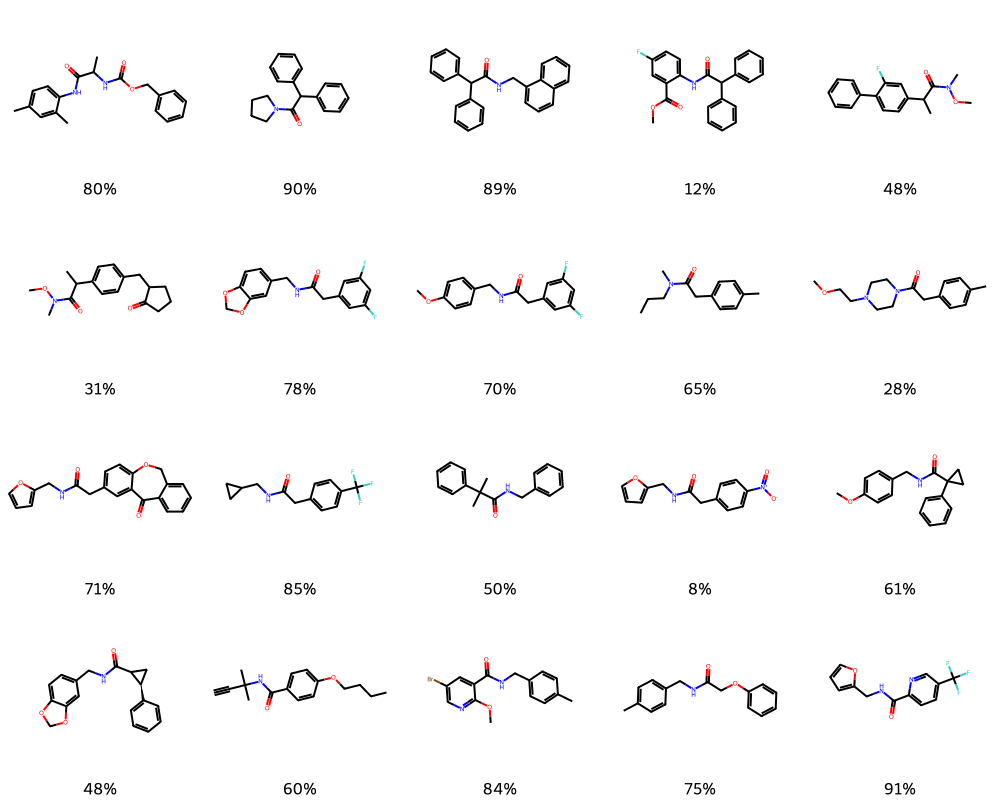

Products selected by the subsequent clustering algorithm for the high dataset:


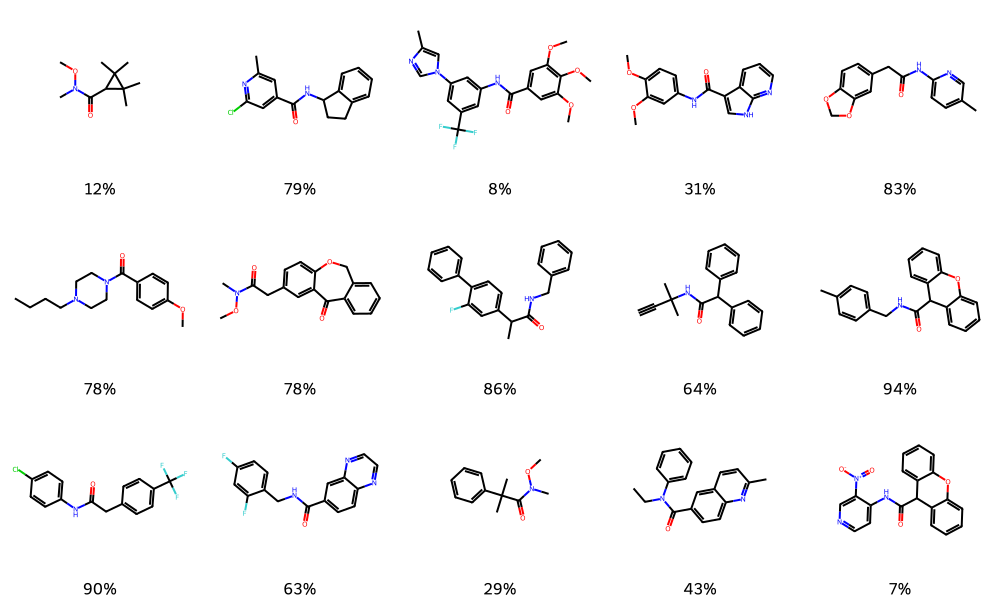




Products selected as the classical scope for the medium dataset:


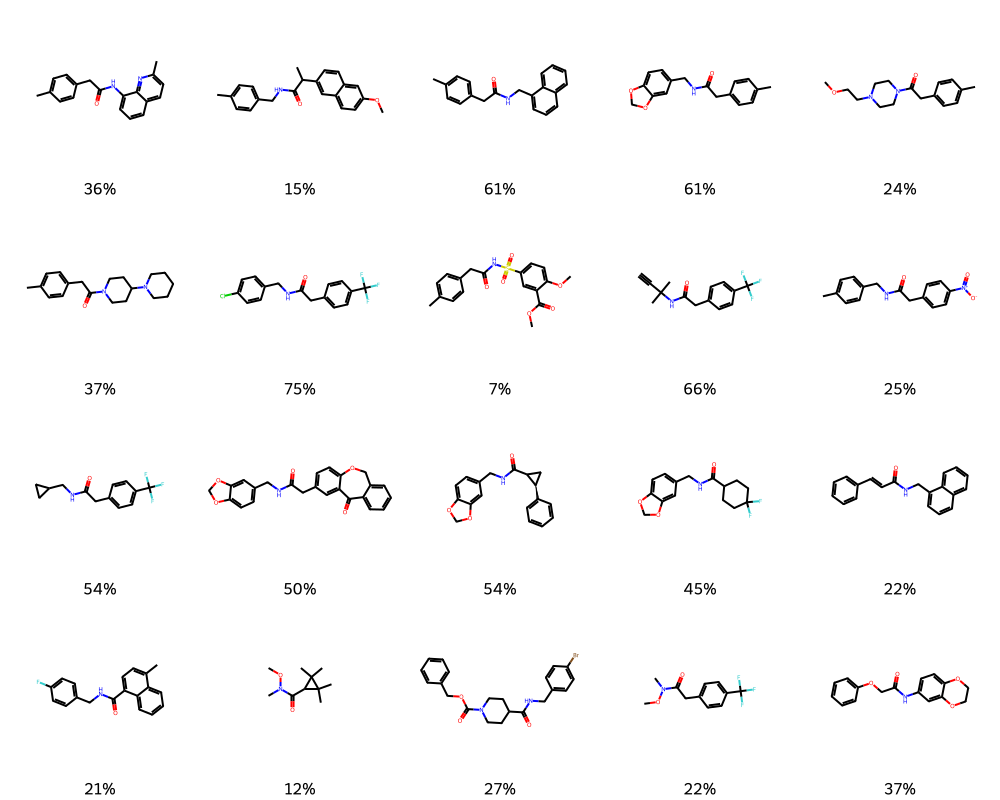

Products selected by the subsequent clustering algorithm for the medium dataset:


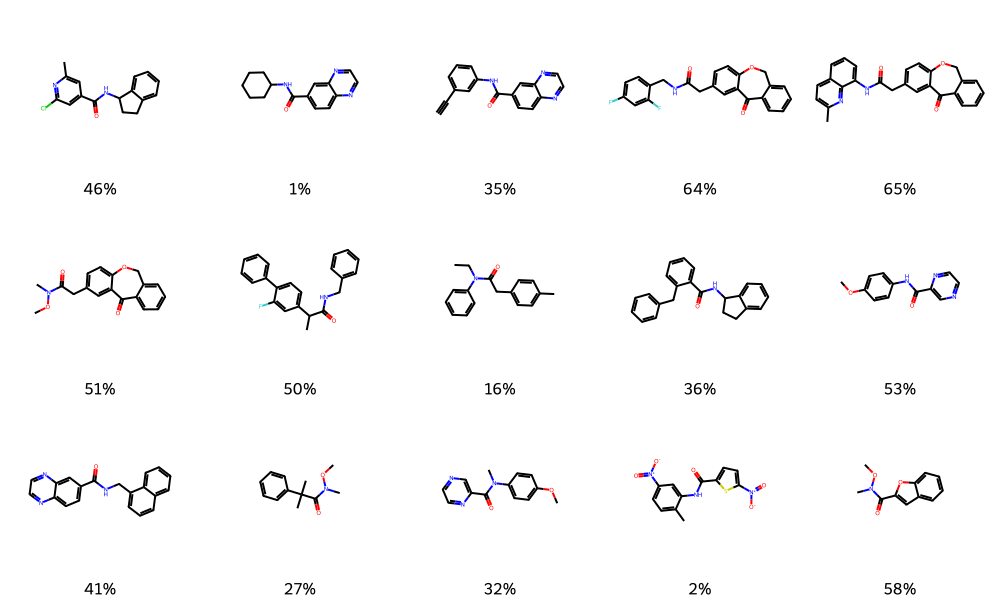




Products selected as the classical scope for the low dataset:


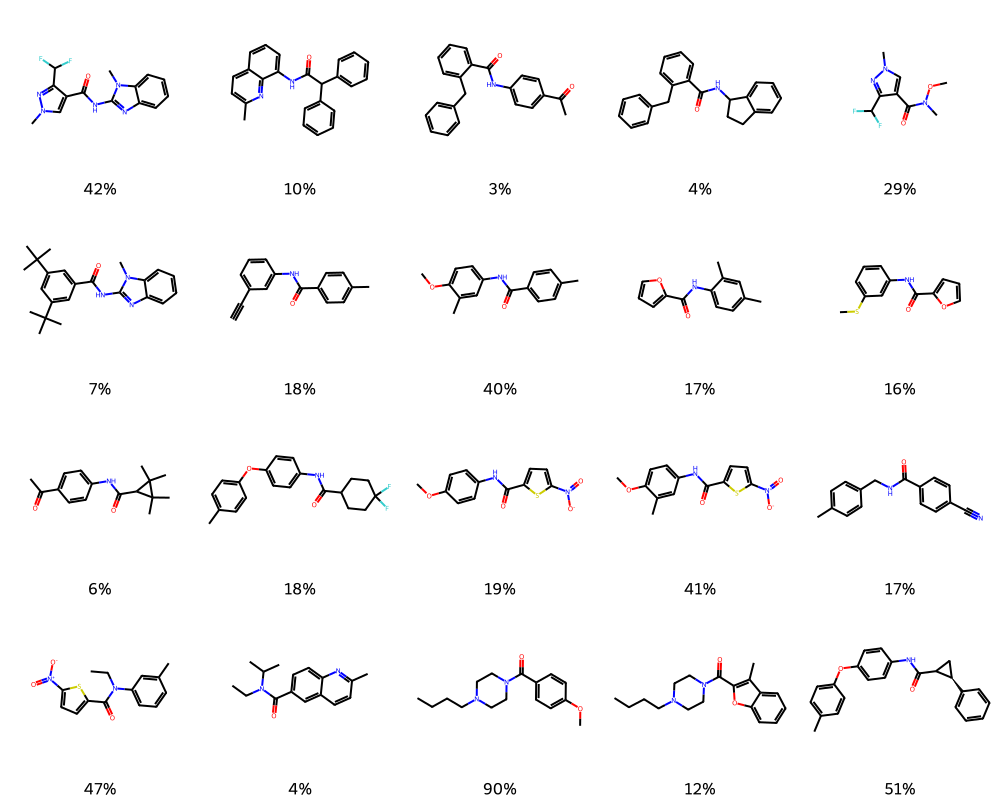

Products selected by the subsequent clustering algorithm for the low dataset:


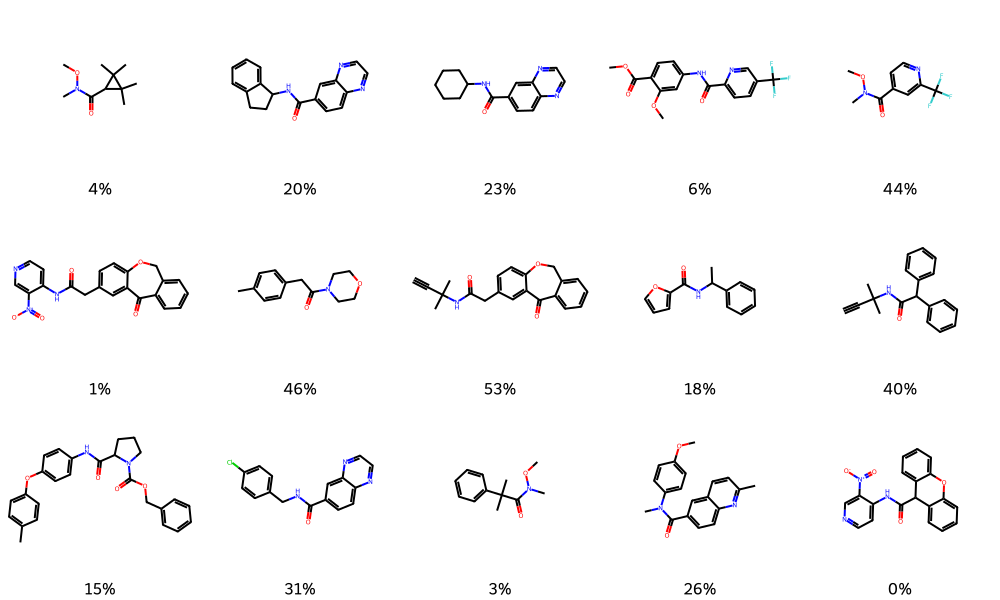

In [18]:
dfs_data_clust = {}
for dset in datasets:
    df_clustering = pd.read_csv(f"./Results_Data/Cluster_Scopes/"\
                                f"scope_glorius_smiles_comb_{dset}.csv",index_col=0,header=0)
    df_clustering.set_index("smiles",inplace=True)

    df_clustering, dfs_data_clust[dset] = assign_clusterpoints(df_clusterpoints=df_clustering,df_dataset=dfs_labelled[dset])

    for results_type in ["class","clust"]:
        if results_type == "class":
            mol_list = generate_representation(list(classical_smiles[dset].keys()))
            print(f"Products selected as the classical scope for the {dset} dataset:")
            legends = [f"{round(100*val)}%" for val in classical_smiles[dset].values()]
        elif results_type == "clust":
            mol_list = generate_representation(list(df_clustering.index))
            print(f"Products selected by the subsequent clustering algorithm for the {dset} dataset:")
            legends = [f"{round(df_clustering.loc[smiles,'yield']*100)}%" for smiles in df_clustering.index]
        depiction = Draw.MolsToGridImage(
            mol_list,
            molsPerRow=5,
            subImgSize=(200, 200),
            legends=legends
            )
        display(depiction)

    if dset != "low":
        print("\n\n")

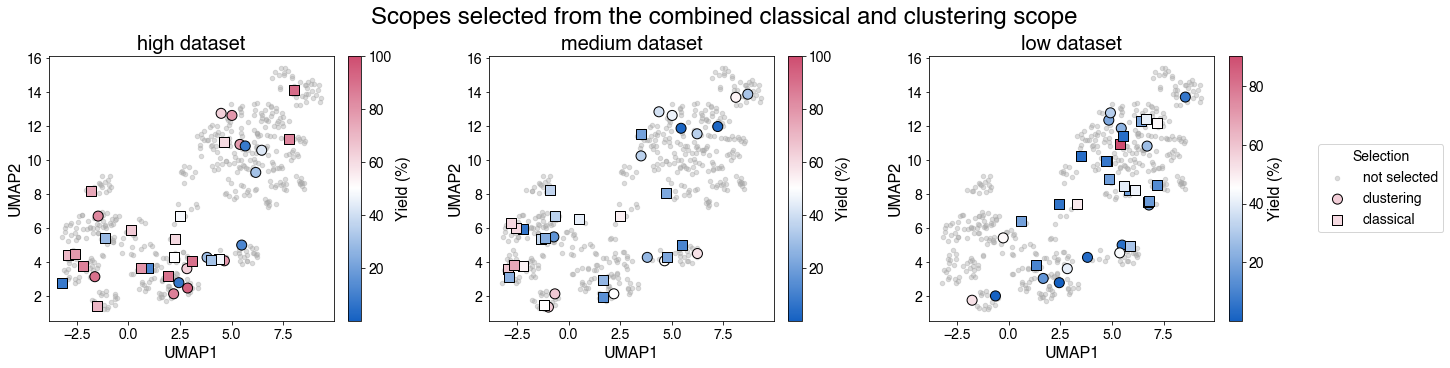

Results for the combined scope of first 20-sample classical scope and then a 15-sample clustering scope:


,Average yield (%),Vendi score,Scope score (combined scope)
high,59.1,4.270,0.073
medium,37.9,4.406,0.079
low,23.5,4.518,0.099


In [19]:
# df to record results
scope_results_class = pd.DataFrame(np.nan,index=datasets,columns=["Average yield (%)", "Vendi score",
                                                                  "Scope score (combined scope)"])

fig,axes = plt.subplots(1,4,figsize=(20,5),gridspec_kw={"wspace":0.1,'width_ratios': [1, 1, 1, 0.3]},constrained_layout=True)
fig.suptitle("Scopes selected from the combined classical and clustering scope")
for i,dset in enumerate(datasets):
    ax = axes[i]
    # combine the two scopes
    data_full = dfs_data_clust[dset].copy()
    for idx in data_full.index:
        if idx in classical_smiles[dset].keys():
            data_full.loc[idx,"yield"] = classical_smiles[dset][idx]

    av_yield = data_full[data_full["yield"] != "PENDING"]["yield"].mean()
    scope_results_class.loc[dset,"Average yield (%)"] = round(av_yield*100,1)
    data_full.to_csv("df_vendi.csv",index=True,header=True)
    vendi_score = ScopeBO().get_vendi_score(objectives=["yield"],filename="df_vendi.csv")
    scope_results_class.loc[dset,"Vendi score"] = round(vendi_score,3)
    bounds = get_bounds(dset,scale_back=True)
    scope_score = calculate_scope_score(av_yield,vendi_score,bounds)
    scope_results_class.loc[dset,"Scope score (combined scope)"] = round(scope_score,3)
    ax.set_title(f"{dset} dataset")
    umap_representation(dfs_data_clust[dset],dset,ax,classical_smiles[dset])
    if i == 0:
        handles_collected, labels_collected = ax.get_legend_handles_labels()
axes[3].axis('off')
axes[3].legend(handles=handles_collected, labels=labels_collected, title = "Selection",
                                                    fontsize=14, loc='center')
plt.show()
print("Results for the combined scope of first 20-sample classical scope and then a 15-sample clustering scope:")
scope_results_class

In [20]:
print("Results for the classical scope before adding the clustering scope:")
classical_scope.drop(columns="Average scope score")

Results for the classical scope before adding the clustering scope:


,Seed,Seed average yield (%),Seed Vendi score,Seed scope score
high,27.0,61.152197,4.145263,0.087894
medium,14.0,37.490083,4.179715,0.058792
low,9.0,24.503440,4.290227,0.096089


In [21]:
# save the results
classical_scope.to_csv("./Results_Data/Cluster_Scopes/results_glorius_class.csv",index=True,header=True)
scope_results_class.to_csv("./Results_Data/Cluster_Scopes/results_glorius_comb.csv",index=True,header=True)
scope_results_15sam.to_csv("./Results_Data/Cluster_Scopes/results_glorius_15samples.csv",index=True,header=True)

In the classical scopes, medium average rates and medium Vendi scores are obtained.

For two datasets, the average yield drops going from the classical scope to the combined scope for two datasets, and it slightly increases for the third one. This is because the clustering algorithm does not consider the objective performance of the selected substrates in its selection. The Vendi scores increase only slightly going form the classical to the combined scopes.

Overall, the combined scopes for the different dataset also have lower scope scores than the ones obtained with ScopeBO.